In [1]:
import numpy as np
import pandas as pd
from reddit_dataclass import RedditData as reddit
import pickle
import matplotlib.pyplot as plt
import scipy.stats as scpstat
import matplotlib.dates as dates
import datetime
from sklearn import metrics
import statsmodels.formula.api as smf
import statsmodels.api as sm
from patsy import dmatrices

In [2]:
infile = "calval_regression_data.p"
outfile = 'author_activity_calibrate_validate_regressions.xlsx'
remove = 'thedonald'
train = True

In [3]:
def log_plus_1(x):
    return np.log(x+1)

def get_skewness(df):
    skew_dict = {}
    for key in df:
        dummy_dict = {}
        if train:
            for type in df[key]:
                dummy_dict[f'{type}_sentiment_magnitude'] = scpstat.skew(df[key][type].sentiment_magnitude)
                dummy_dict[f'{type}_log(mag+1)'] = scpstat.skew(df[key][type].log_sentiment_magnitude_plus_one)
                dummy_dict[f'{type}_sqrt(mag)'] = scpstat.skew(df[key][type].sqrt_sentiment_magnitude)
                dummy_dict[f'{type}_post_activity_count'] = scpstat.skew(df[key][type].post_activity_count)
                dummy_dict[f'{type}_log(post_activity)'] = scpstat.skew(df[key][type].log_post_activity_count)
                dummy_dict[f'{type}_sqrt(post_activity)'] = scpstat.skew(df[key][type].sqrt_post_activity_count)

        else:
            dummy_dict['sentiment_magnitude'] = scpstat.skew(df[key].sentiment_magnitude)
            dummy_dict['log(mag+1)'] = scpstat.skew(df[key].log_sentiment_magnitude_plus_one)
            dummy_dict['sqrt(mag)'] = scpstat.skew(df[key].sqrt_sentiment_magnitude)
            dummy_dict['post_activity_count'] = scpstat.skew(df[key].post_activity_count)
            dummy_dict['log(post_activity)'] = scpstat.skew(df[key].log_post_activity_count)
            dummy_dict['sqrt(post_activity)'] = scpstat.skew(df[key].sqrt_post_activity_count)
        skew_dict[key] = pd.DataFrame.from_dict(dummy_dict, orient='index').rename(columns={0: key})

    skew_df = pd.DataFrame({'A' : []})

    for key in skew_dict:
        if skew_df.empty:
            skew_df = skew_dict[key]
        else:
            skew_df = pd.concat((skew_df, skew_dict[key]), axis=1)
    
    return skew_df

def perform_models_regressions(dataset, models):

    # perform regressions
    regression_parameters_by_model = {}
    for i, model in enumerate(models):
        regression_parameters_dict = {}
        for key in dataset:
            logistic_regression = smf.logit(
                model,
                data=dataset[key]
            ).fit()
            # fit parameter dictionary
            regression_parameters_dict[key] = logistic_regression.params

            # calculate AUC
            y_predicted = logistic_regression.predict()
            y_real = dataset[key].success
            auc = metrics.roc_auc_score(y_real,  y_predicted)

            regression_parameters_dict[key]['auc'] = auc

        regression_parameters_by_model[i] = pd.DataFrame.from_dict(regression_parameters_dict)
    
    # add model number to multiindex
    for model_number in regression_parameters_by_model:
        regression_parameters_by_model[model_number].set_index(
            [[model_number]*len(regression_parameters_by_model[model_number]),
            regression_parameters_by_model[model_number].index],
            inplace=True 
            )
        regression_parameters_by_model[model_number].index.set_names(['model', 'parameter'], inplace=True)
    
    # combine to form one df for all models run
    for key in regression_parameters_by_model:
        if key == 0:
            all_regression_params = regression_parameters_by_model[key]
        else:
            all_regression_params = pd.concat((all_regression_params, regression_parameters_by_model[key]))
        
    return all_regression_params

def perform_calibration_validation_regressions(dataset, models):

    # perform regressions
    regression_parameters_by_model = {}
    for i, model in enumerate(models):
        regression_parameters_dict = {}
        for key in dataset:
            logistic_regression = smf.logit(
                model,
                data=dataset[key]['calibration']
            ).fit()
            # fit parameter dictionary
            regression_parameters_dict[key] = logistic_regression.params

            # calculate calibration AUC
            y_predicted = logistic_regression.predict()
            y_real = dataset[key]['calibration'].success
            auc = metrics.roc_auc_score(y_real,  y_predicted)

            regression_parameters_dict[key]['calibration_auc'] = auc

            # calculate validation AUC
            y_predicted = logistic_regression.predict(
                exog = dataset[key]['validation']
            )
            y_real = dataset[key]['validation'].success
            auc = metrics.roc_auc_score(y_real,  y_predicted)
            regression_parameters_dict[key]['validation_auc'] = auc

        regression_parameters_by_model[i] = pd.DataFrame.from_dict(regression_parameters_dict)
    
    # add model number to multiindex
    for model_number in regression_parameters_by_model:
        regression_parameters_by_model[model_number].set_index(
            [[model_number]*len(regression_parameters_by_model[model_number]),
            regression_parameters_by_model[model_number].index],
            inplace=True 
            )
        regression_parameters_by_model[model_number].index.set_names(['model', 'parameter'], inplace=True)
    
    # combine to form one df for all models run
    for key in regression_parameters_by_model:
        if key == 0:
            all_regression_params = regression_parameters_by_model[key]
        else:
            all_regression_params = pd.concat((all_regression_params, regression_parameters_by_model[key]))
        
    return all_regression_params

In [4]:
regression_thread_data = pickle.load(open(infile, 'rb'))
if remove:
    regression_thread_data.pop(remove)

for key in regression_thread_data:
    if train:
        for type in regression_thread_data[key]:
            regression_thread_data[key][type]['log_sentiment_magnitude_plus_one'] = log_plus_1(regression_thread_data[key][type].sentiment_magnitude)
            regression_thread_data[key][type]['sqrt_sentiment_magnitude'] = np.sqrt(regression_thread_data[key][type].sentiment_magnitude)
            regression_thread_data[key][type]['log_post_activity_count'] = np.log(regression_thread_data[key][type].post_activity_count)
            regression_thread_data[key][type]['sqrt_post_activity_count'] = np.sqrt(regression_thread_data[key][type].post_activity_count)
    else:
        regression_thread_data[key]['log_sentiment_magnitude_plus_one'] = log_plus_1(regression_thread_data[key].sentiment_magnitude)
        regression_thread_data[key]['sqrt_sentiment_magnitude'] = np.sqrt(regression_thread_data[key].sentiment_magnitude)
        regression_thread_data[key]['log_post_activity_count'] = np.log(regression_thread_data[key].post_activity_count)
        regression_thread_data[key]['sqrt_post_activity_count'] = np.sqrt(regression_thread_data[key].post_activity_count)

In [5]:
regression_thread_data['books']['calibration'].columns

Index(['thread_id', 'thread_size', 'authors', 'timestamp', 'author', 'score',
       'subject_sentiment_score', 'sentiment_sign', 'sentiment_magnitude',
       'success', 'all_activity_count', 'post_activity_count',
       'comment_activity_count', 'log_sentiment_magnitude_plus_one',
       'sqrt_sentiment_magnitude', 'log_post_activity_count',
       'sqrt_post_activity_count'],
      dtype='object')

In [21]:

X_train = regression_thread_data['crypto']['calibration'][[
    'sentiment_sign', 'sentiment_magnitude', 'post_activity_count',
    'comment_activity_count'
    ]]
y_train = regression_thread_data['crypto']['calibration']['success']

In [8]:
# adapted from https://www.datasklr.com/ols-least-squares-regression/variable-selection
#RECURSIVE FEATURE ELIMINATION
#Feature ranking with recursive feature elimination and cross-validated selection of the best number of features

from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression



names=pd.DataFrame(X_train.columns)

#use logistic regression as the model
log_reg = LogisticRegression()

#This is to select 5 variables: can be changed and checked in model for accuracy
rfecv_mod = RFECV(log_reg, step=1, cv=5) 
myvalues=rfecv_mod.fit(X_train,y_train) #to fit
myvalues.support_#The mask of selected features.
myvalues.ranking_ #The feature ranking, such that ranking_[i] corresponds to the ranking position of the i-th feature. Selected (i.e., estimated best) features are assigned rank 1.

rankings=pd.DataFrame(myvalues.ranking_) #Make it into data frame
rankings

,0
0,1
1,1
2,1
3,1


In [7]:
ranked=pd.concat([names,rankings], axis=1)
ranked.columns = ["Feature", "Rank"]
ranked

#Select most important (Only 1's)
most_important = ranked.loc[ranked['Rank'] ==1] 
print(most_important)

most_important['Rank'].count()

                  Feature  Rank
0          sentiment_sign     1
1     sentiment_magnitude     1
2     post_activity_count     1
3  comment_activity_count     1


4

Tutorial used:


http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/


In [88]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from mlxtend.feature_selection import SequentialFeatureSelector


scoring_method = 'roc_auc'
# perform stepwise regression
# forward selection
print('Sequential Forward selection')
#for k in range(1,5):
k=4
sfs = SequentialFeatureSelector(linear_model.LogisticRegression(),
                                k_features = k,
                                forward=True,
                                scoring=scoring_method,
                                cv=None,)
selected_features = sfs.fit(X_train, y_train)
print(f'k={k} selected features: {selected_features.k_feature_names_}')
#display(selected_features.subsets_)
display(pd.DataFrame.from_dict(selected_features.get_metric_dict(), orient='index'))

print('Floating Forward selection')
#for k in range(1,5):

sfs = SequentialFeatureSelector(linear_model.LogisticRegression(),
                                k_features = k,
                                forward=True,
                                scoring=scoring_method,
                                floating=True,
                                cv=None,)
selected_features = sfs.fit(X_train, y_train)
print(f'k={k} selected features: {selected_features.k_feature_names_}')
#display(selected_features.subsets_)
display(pd.DataFrame.from_dict(selected_features.get_metric_dict(), orient='index'))

# backward selection
print('\n Sequential Backward selection')
k=1
#for k in range(1,5):
sfs = SequentialFeatureSelector(linear_model.LogisticRegression(),
                                k_features = k,
                                forward=False,
                                scoring=scoring_method,
                                cv=None)
selected_features = sfs.fit(X_train, y_train)
print(f'k={k} selected features: {selected_features.k_feature_names_}')
display(pd.DataFrame.from_dict(selected_features.get_metric_dict(), orient='index'))

print('\n Floating Backward selection')
#for k in range(1,5):
sfs = SequentialFeatureSelector(linear_model.LogisticRegression(),
                                k_features = k,
                                forward=False,
                                scoring=scoring_method,
                                floating=True,
                                cv=None)
selected_features = sfs.fit(X_train, y_train)
print(f'k={k} selected features: {selected_features.k_feature_names_}')
display(pd.DataFrame.from_dict(selected_features.get_metric_dict(), orient='index'))

Sequential Forward selection
k=4 selected features: ('sentiment_sign', 'sentiment_magnitude', 'post_activity_count', 'comment_activity_count')


/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(3,)",[0.8185895728905598],0.818590,"(comment_activity_count,)",NaN,0.0,NaN
2,"(2, 3)",[0.7718789719835302],0.771879,"(post_activity_count, comment_activity_count)",NaN,0.0,NaN
3,"(1, 2, 3)",[0.758764116392171],0.758764,"(sentiment_magnitude, post_activity_count, com...",NaN,0.0,NaN
4,"(0, 1, 2, 3)",[0.7556305197517603],0.755631,"(sentiment_sign, sentiment_magnitude, post_act...",NaN,0.0,NaN


Floating Forward selection
k=4 selected features: ('sentiment_sign', 'sentiment_magnitude', 'post_activity_count', 'comment_activity_count')


/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(3,)",[0.8185895728905598],0.818590,"(comment_activity_count,)",NaN,0.0,NaN
2,"(2, 3)",[0.7718789719835302],0.771879,"(post_activity_count, comment_activity_count)",NaN,0.0,NaN
3,"(1, 2, 3)",[0.758764116392171],0.758764,"(sentiment_magnitude, post_activity_count, com...",NaN,0.0,NaN
4,"(0, 1, 2, 3)",[0.7556305197517603],0.755631,"(sentiment_sign, sentiment_magnitude, post_act...",NaN,0.0,NaN



 Sequential Backward selection
k=1 selected features: ('comment_activity_count',)


/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
4,"(0, 1, 2, 3)",[0.7556305197517603],0.755631,"(sentiment_sign, sentiment_magnitude, post_act...",NaN,0.0,NaN
3,"(1, 2, 3)",[0.758764116392171],0.758764,"(sentiment_magnitude, post_activity_count, com...",NaN,0.0,NaN
2,"(2, 3)",[0.7718789719835302],0.771879,"(post_activity_count, comment_activity_count)",NaN,0.0,NaN
1,"(3,)",[0.8185895728905598],0.818590,"(comment_activity_count,)",NaN,0.0,NaN



 Floating Backward selection
k=1 selected features: ('comment_activity_count',)


/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
4,"(0, 1, 2, 3)",[0.7556305197517603],0.755631,"(sentiment_sign, sentiment_magnitude, post_act...",NaN,0.0,NaN
3,"(1, 2, 3)",[0.758764116392171],0.758764,"(sentiment_magnitude, post_activity_count, com...",NaN,0.0,NaN
2,"(2, 3)",[0.7718789719835302],0.771879,"(post_activity_count, comment_activity_count)",NaN,0.0,NaN
1,"(3,)",[0.8185895728905598],0.818590,"(comment_activity_count,)",NaN,0.0,NaN


In [47]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

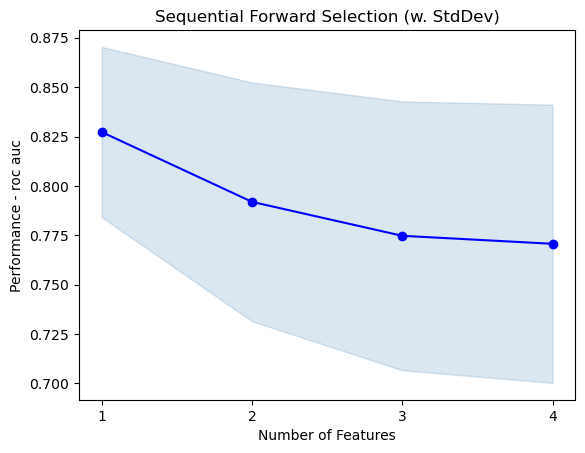

In [64]:
sfs = SequentialFeatureSelector(linear_model.LogisticRegression(),
                                k_features = 4,
                                forward=True,
                                scoring='roc_auc',
                                floating=False,
                                cv=5)
selected_features = sfs.fit(X_train, y_train)
fig1 = plot_sfs(selected_features.get_metric_dict(), kind='std_dev')
plt.title('Sequential Forward Selection (w. StdDev)')
plt.ylabel('Performance - roc auc')
plt.show()

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score

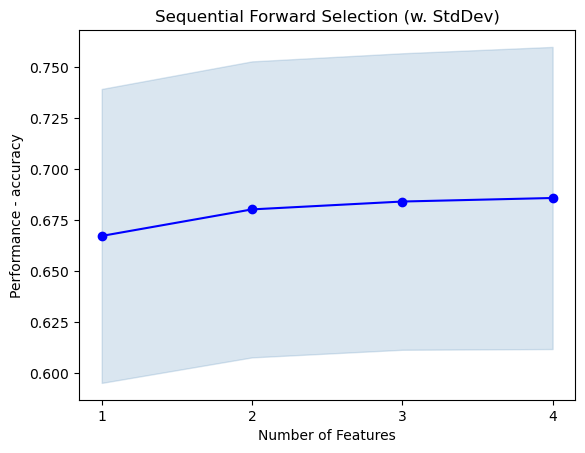

In [65]:
sfs = SequentialFeatureSelector(linear_model.LogisticRegression(),
                                k_features = 4,
                                forward=True,
                                scoring='accuracy',
                                floating=False,
                                cv=5)
selected_features = sfs.fit(X_train, y_train)
fig1 = plot_sfs(selected_features.get_metric_dict(), kind='std_dev')
plt.title('Sequential Forward Selection (w. StdDev)')
plt.ylabel('Performance - accuracy')
plt.show()


# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html


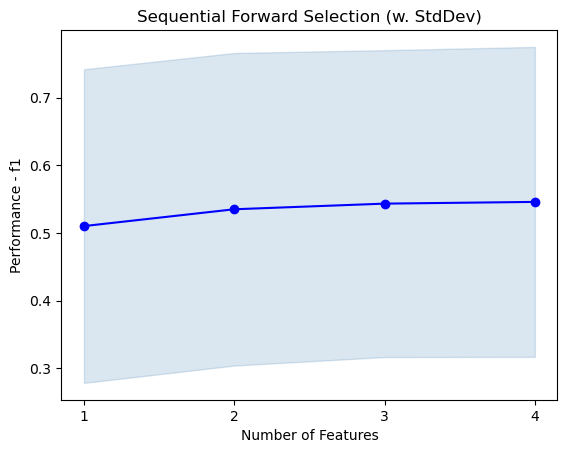

In [66]:
sfs = SequentialFeatureSelector(linear_model.LogisticRegression(),
                                k_features = 4,
                                forward=True,
                                scoring='f1',
                                floating=False,
                                cv=5)
selected_features = sfs.fit(X_train, y_train)
fig1 = plot_sfs(selected_features.get_metric_dict(), kind='std_dev')
plt.title('Sequential Forward Selection (w. StdDev)')
plt.ylabel('Performance - f1')
plt.show()

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score

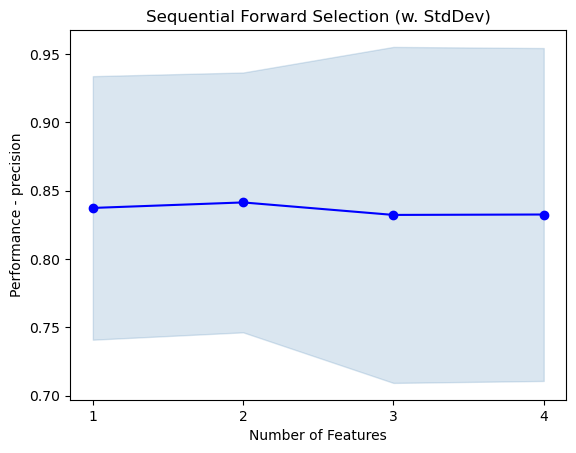

In [67]:
sfs = SequentialFeatureSelector(linear_model.LogisticRegression(),
                                k_features = 4,
                                forward=True,
                                scoring='precision',
                                floating=False,
                                cv=5)
selected_features = sfs.fit(X_train, y_train)
fig1 = plot_sfs(selected_features.get_metric_dict(), kind='std_dev')
plt.title('Sequential Forward Selection (w. StdDev)')
plt.ylabel('Performance - precision')
plt.show()

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score

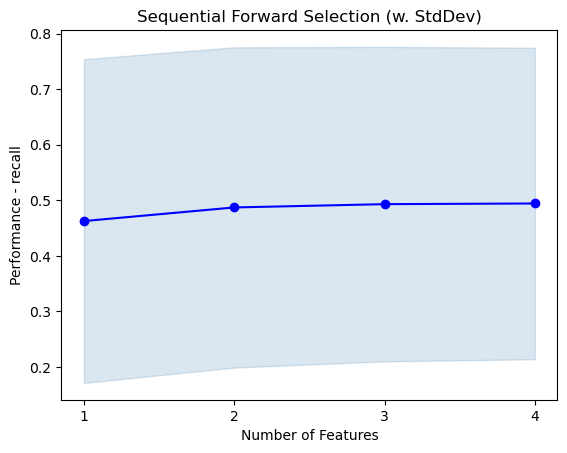

In [68]:
sfs = SequentialFeatureSelector(linear_model.LogisticRegression(),
                                k_features = 4,
                                forward=True,
                                scoring='recall',
                                floating=False,
                                cv=5)
selected_features = sfs.fit(X_train, y_train)
fig1 = plot_sfs(selected_features.get_metric_dict(), kind='std_dev')
plt.title('Sequential Forward Selection (w. StdDev)')
plt.ylabel('Performance - recall')
plt.show()

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score

In [82]:

X_train = regression_thread_data['crypto']['calibration'][[
    'sentiment_sign', 'sentiment_magnitude', 'post_activity_count',
    'comment_activity_count'
    ]]
X_test = regression_thread_data['crypto']['validation'][[
    'sentiment_sign', 'sentiment_magnitude', 'post_activity_count',
    'comment_activity_count'
    ]]
y_train = regression_thread_data['crypto']['calibration']['success']
y_test = regression_thread_data['crypto']['validation']['success']

In [85]:
sfs1  = SequentialFeatureSelector(linear_model.LogisticRegression(),
                                  k_features=1,
                                  forward=True,
                                  floating=False,
                                  scoring='roc_auc',
                                  cv=5)
sfs1 = sfs1.fit(X_train, y_train)
print(f'Selected features: {sfs1.k_feature_names_}')

Selected features: ('comment_activity_count',)


In [92]:
# Generate the new subsets based on the selected features
# Note that the transform call is equivalent to
# X_train[:, sfs1.k_feature_idx_]

X_train_sfs = sfs1.transform(X_train)
X_test_sfs = sfs1.transform(X_test)

# Fit the estimator using the new feature subset
# and make a prediction on the test data
logit = linear_model.LogisticRegression()
logit.fit(X_train_sfs, y_train)
y_pred = logit.predict(X_test_sfs)

# Compute the accuracy of the prediction
acc = float((y_test == y_pred).sum()) / y_pred.shape[0]
print('Test set accuracy: %.2f %%' % (acc * 100))

auc = metrics.roc_auc_score(y_test,  y_pred)
print('Test set ROC AUC: %.2f' % (auc))

Test set accuracy: 63.92 %
Test set ROC AUC: 0.58


In [93]:
sfs2  = SequentialFeatureSelector(linear_model.LogisticRegression(),
                                  k_features=2,
                                  forward=True,
                                  floating=False,
                                  scoring='roc_auc',
                                  cv=5)
sfs2 = sfs2.fit(X_train, y_train)
print(f'Selected features: {sfs2.k_feature_names_}')

# Generate the new subsets based on the selected features
# Note that the transform call is equivalent to
# X_train[:, sfs1.k_feature_idx_]

X_train_sfs = sfs2.transform(X_train)
X_test_sfs = sfs2.transform(X_test)

# Fit the estimator using the new feature subset
# and make a prediction on the test data
logit = linear_model.LogisticRegression()
logit.fit(X_train_sfs, y_train)
y_pred = logit.predict(X_test_sfs)

# Compute the accuracy of the prediction
acc = float((y_test == y_pred).sum()) / y_pred.shape[0]
print('Test set accuracy: %.2f %%' % (acc * 100))

auc = metrics.roc_auc_score(y_test,  y_pred)
print('Test set ROC AUC: %.2f' % (auc))

Selected features: ('post_activity_count', 'comment_activity_count')
Test set accuracy: 65.79 %
Test set ROC AUC: 0.60


In [94]:
sfs3  = SequentialFeatureSelector(linear_model.LogisticRegression(),
                                  k_features=3,
                                  forward=True,
                                  floating=False,
                                  scoring='roc_auc',
                                  cv=5)
sfs3 = sfs3.fit(X_train, y_train)
print(f'Selected features: {sfs3.k_feature_names_}')

# Generate the new subsets based on the selected features
# Note that the transform call is equivalent to
# X_train[:, sfs1.k_feature_idx_]

X_train_sfs = sfs3.transform(X_train)
X_test_sfs = sfs3.transform(X_test)

# Fit the estimator using the new feature subset
# and make a prediction on the test data
logit = linear_model.LogisticRegression()
logit.fit(X_train_sfs, y_train)
y_pred = logit.predict(X_test_sfs)

# Compute the accuracy of the prediction
acc = float((y_test == y_pred).sum()) / y_pred.shape[0]
print('Test set accuracy: %.2f %%' % (acc * 100))

auc = metrics.roc_auc_score(y_test,  y_pred)
print('Test set ROC AUC: %.2f' % (auc))

Selected features: ('sentiment_magnitude', 'post_activity_count', 'comment_activity_count')
Test set accuracy: 65.77 %
Test set ROC AUC: 0.60


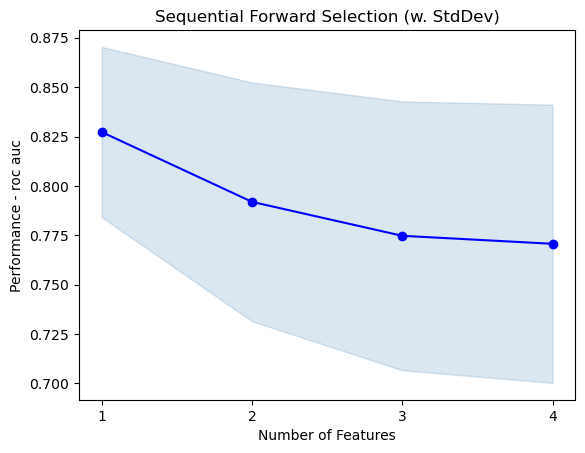

In [95]:


sfs = SequentialFeatureSelector(linear_model.LogisticRegression(),
                                k_features = (1,4),
                                forward=True,
                                scoring='roc_auc',
                                floating=False,
                                cv=5)
selected_features = sfs.fit(X_train, y_train)
fig1 = plot_sfs(selected_features.get_metric_dict(), kind='std_dev')
plt.title('Sequential Forward Selection (w. StdDev)')
plt.ylabel('Performance - roc auc')
plt.show()

In [97]:
print('Sequential Forward selection')
sfs = SequentialFeatureSelector(linear_model.LogisticRegression(),
                                k_features = (1,4),
                                forward=True,
                                scoring=scoring_method,
                                cv=None,)
selected_features = sfs.fit(X_train, y_train)
print(f'selected features: {selected_features.k_feature_names_}')
#display(selected_features.subsets_)
display(pd.DataFrame.from_dict(selected_features.get_metric_dict(), orient='index'))


Sequential Forward selection
selected features: ('comment_activity_count',)


/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(3,)",[0.8185895728905598],0.818590,"(comment_activity_count,)",NaN,0.0,NaN
2,"(2, 3)",[0.7718789719835302],0.771879,"(post_activity_count, comment_activity_count)",NaN,0.0,NaN
3,"(1, 2, 3)",[0.758764116392171],0.758764,"(sentiment_magnitude, post_activity_count, com...",NaN,0.0,NaN
4,"(0, 1, 2, 3)",[0.7556305197517603],0.755631,"(sentiment_sign, sentiment_magnitude, post_act...",NaN,0.0,NaN
